# <h1>Assignment 2 - CV</h1>

## Members
- Bruno Silva up201906367
- João Castro up201904859

The project chosen was <b>Project 2 – Captcha decoding</b>.

In [ ]:
!jupyter nbconvert --to html "ML_project2.ipynb"

[NbConvertApp] Converting notebook ML_project2.ipynb to html
[NbConvertApp] Writing 1022826 bytes to ML_project2.html


In [1]:
# Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [2]:
# Get the direct download link for the ZIP file from Dropbox
!wget -O CAPTCHA_dataset_ziperson.zip https://www.dropbox.com/scl/fi/4l8yle6onmba4o0d2e7dc/CAPTCHA_dataset_ziperson.zip?rlkey=8qq8klth2pchqn5s9jonp1jyo&dl=0

# Unzip the data to the directory DATA_coins
!unzip CAPTCHA_dataset_ziperson.zip -d Dataset

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: Dataset/CAPTCHA_dataset/soft/train/51958.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/52109.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/52211.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/5223.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/52313.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/5235.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/52374.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/52383.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/5255.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/5270.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/5276.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/53148.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/53262.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/5330.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/533w.png  
  inflating: Dataset/CAPTCHA_dataset/soft/train/

# Introduction

The aim of this project was to develop a Convolutional Neural Network (CNN) capable of decoding CAPTCHAs (Completely Automated Touring test to Tell Computers and Humans Apart). Many websites use these features to prevent bot raiding, promotion spam, data scraping amongst other methods to abuse websites.

The sets of images that were provided consisted of two major groups:

* Soft Images
* Hard Images





4 Encoders


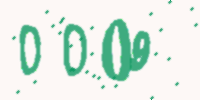

5 Encoders


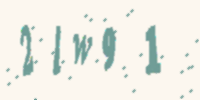

In [3]:
# @title Soft Images
soft_4 = cv2.imread('/content/Dataset/CAPTCHA_dataset/soft/test/0009.png')
soft_5 = cv2.imread('/content/Dataset/CAPTCHA_dataset/soft/test/2lw91.png')

print('4 Encoders')
cv2_imshow(soft_4)

print('5 Encoders')
cv2_imshow(soft_5)

4 Encoders


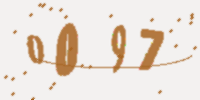

5 Encoders


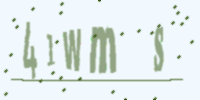

In [4]:
# @title Hard Images

hard_4 = cv2.imread('/content/Dataset/CAPTCHA_dataset/hard/test/0097.png')
hard_5 = cv2.imread('/content/Dataset/CAPTCHA_dataset/hard/test/41wms.png')

print('4 Encoders')
cv2_imshow(hard_4)

print('5 Encoders')
cv2_imshow(hard_5)

The main difference between these two sets of images is that in the hard images there is added noise to make the identification more difficult to predict. With this in mind, the first approach taken was to design, implement and train a CNN that could identify the digits from the Soft Dataset. Once the model for the Soft Dataset started showing good results and there was an idea of what configuration was working for the Neural Network, the Hard Dataset was addressed along with some tweaks to its preprocessing.

### State of the Art

Firstly, it was necessary to understand how the CNN would be trained. Two approachs were taken into consideration:

* Train the CNN with whole image and the respective CAPTCHA label
* Segment the digits in the CAPTCHA and then feed the CNN with the segmented images associated with their respective label

<br>

Training the CNN with the whole image had some advantages such as: not needing any segmentation, not depending as heavily on traditional computer vision techniques, etc. But the downsides were pretty impactful: it needed a very complex and precise Convolutional Layer and the results, according to State of the Art, were not the best in comparison to the second approach.

The second approach being segmenting all the letters and numbers in the CAPTCHAs and then train the CNN with this data. This way, the CNN would learn features from each character with much more precision and uniqueness.



# Development

##Soft Dataset

In the first stage of this project it is intended to identify the digits present in the images from the Soft Dataset. To accomplish this, a work plan was traced with the necessary steps to achieve this goal.


### Preprocessing

In order to segment the initial image in individual characters, a preprocess method ```preprocessing_testing``` was used which used traditional image processing methods such as Gaussian adaptive binary threshold, small blob removal, contour finding, and image cropping. Just applying this set of transformation was performing positively if the image did not have two characters adjacent. In this situation, due to the find contours method, the number of cropped individual images was smaller than the number of labels. This matter happened with 10% of the soft dataset, which meant that 10% of the CAPTCHA images was being discarded due to bad segmentation.

To fix this, another step was added to the preprocessing: if the number of individual images was smaller than the number of labels, the individual image with the largest width would be cropped exactly in the middle, width-wise. The list of images was then adjusted to receive each half of this segmentation in the correct postions. After checking the number of CAPTCHA images well segmented after this modification, a $99.51\%$ sucess rate was obtained using the images in the soft train, which was a satisfactory value.

The results of the preprocessing methods used were as follows:

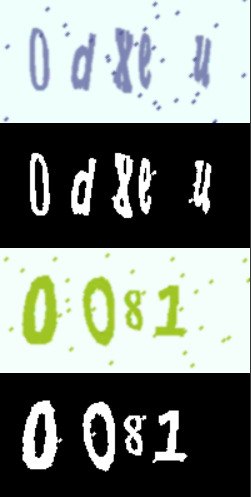

Figure 1 - Prepocessing traditional methods results

<br>

To normalize each individual image, a resize was also applied into the dimensions of 64x64px. Finally at the end of the preprocessing a list of 4 or 5 individual binary 64x64 gray-scale images was returned.

<br>

Since the type of variables used by PyTorch when building the dataloaders was tensor, it was decided to use ints as labels instead of chars. A simple conversion was formulated:


\begin{array}{c|c}
\hline
Char                      & Int                     \\ \hline
'0'                       & 0                       \\
'1'                       & 1                       \\
'2'                       & 2                       \\
'3'                       & 3                       \\
...                       & ...                     \\
'9'                       & 9                       \\
'a'                       & 10                      \\
'b'                       & 11                      \\
...                       & ...                     \\
'z'                       & 35                      \\ \hline
\end{array}

<br>

Two functions ```convert_char_to_int``` and ```convert_int_to_char``` were made to aid the conversions char->int and int->char, both presented below.




In [5]:
def convert_char_to_int(char):
    if char.isdigit():
        return int(char)
    elif char.islower():
        return ord(char) - ord('a') + 10
    else:
        raise ValueError(f"Invalid character: {char}")

In [6]:
def convert_int_to_char(value):
    if 0 <= value <= 9:
        return str(value)
    elif 10 <= value <= 35:
        return chr(value - 10 + ord('a'))
    else:
        raise ValueError(f"Invalid integer value: {value}")

In [7]:
def preprocess_testing(img, label):

  letters = []

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  thresh2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,21,2)

  #cv2_imshow(thresh2)

  #Label connected components and get statistics
  num_labels, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(thresh2, connectivity=8)

  # Filter out small blobs based on area
  min_blob_area = 80 # Adjust this threshold as needed
  filtered_image = np.zeros_like(thresh2)
  for bruh in range(1, num_labels):
      if stats[bruh, cv2.CC_STAT_AREA] > min_blob_area:
          filtered_image[labeled_image == bruh] = 255

  #cv2_imshow(filtered_image)

  contours, _ = cv2.findContours(filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])


  for c in contours:

    # Select the ROI of the paper sheet
    if(cv2.arcLength(c, True) > 50):

      # Calculate the bounding rectangle for the contour
      x, y, w, h = cv2.boundingRect(c)

      # Draw the bounding rectangle on the image
      #cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

      # Crop the region defined by the rectangle
      cropped_region = filtered_image[y:y + h, x:x + w]

      #resized_letter = cv2.resize(cropped_region, (64, 64))
      letters.append(cropped_region)

  # split the images containing 2 letters due to bad segmentation
  if(len(letters) != len(label) and len(letters) > 0):
    # Find the index of the letter with the maximum width
    max_width_index = max(range(len(letters)), key=lambda i: letters[i].shape[1])

    # Get the region with the maximum width
    max_width_region = letters[max_width_index]

    # Perform the cropping (assuming you want to split it into two equal halves)
    h, w = max_width_region.shape
    half_width = w // 2

    # Crop the left half
    left_half = max_width_region[:, :half_width]

    # Crop the right half
    right_half = max_width_region[:, half_width:]

    # Replace the letter with the two halves
    letters.pop(max_width_index)
    letters.insert(max_width_index, left_half)
    letters.insert(max_width_index + 1, right_half)

  letters_corrected = []

  for img in letters:
    resized_letter = cv2.resize(img, (64, 64))
    letters_corrected.append(resized_letter)

  return letters_corrected


# Directory path containing the images
directory_path = '/content/Dataset/CAPTCHA_dataset/soft/test/'

# File pattern to match
file_pattern = '*.png'

# Get a list of file paths that match the pattern
image_paths = glob.glob(directory_path + file_pattern)

# Variables for counting
total_count = len(image_paths)
seg_count = 0

for image_path in image_paths:
    # Read the image
    img = cv2.imread(image_path)

    # Extract the label from the file name or use a method to get the label
    directory_name = os.path.basename(image_path)
    directory_name = os.path.splitext(directory_name)[0]
    individual_letters = [letter for letter in directory_name]

    img_segmented = preprocess_testing(img, individual_letters)
    if(len(img_segmented) == len(individual_letters)):
      seg_count += 1

print(f'Segmentation Accuracy: {(seg_count/total_count*100):.2f} %')

bruh = cv2.imread('/content/Dataset/CAPTCHA_dataset/soft/test/0dxeu.png')

wow = preprocess_testing(bruh, ['a'])

Segmentation Accuracy: 99.51 %


### Device Selection

To quicken the training process of the network, GPU cuda:0 was priorotized. If that device was not available, the CPU would then be used.  

In [8]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


### Model

The model used for character classification was composed of two parts: convolutional section and the fully-connected section.
The individual layers were as follows:
* **Conv1** - since the individual character images were binary, only 1 channel would enter the first convolution. In the output, 32 channels were generated with a kernel of size 3 and a padding of 1.
* **COnv2** - 32 channels were received fom Conv1 and 64 channels were put at the ouput. The convolution was performed again with a kernel of size 3 and a padding of 1.
* **Pool** - to reduce the dimensions of the feature maps by half, a pooling layer was used with a kernel of size 2 and a stride of 2.
* **Dropout** - a dropout with probability of 0.2 followed by 0.5 was applied, which helped prevent overfitting by randomly setting a fraction of input units to zero during training.
* **Flatten** - used to create a one dimension tensor from the 3 dimension tensor, which allows the connection to the next layer.
* **Fc1** - first fully-connected layer with an input of 64 * 16 * 16 and an output of 1024.
* **Fc2** - second fully-connected layer with an input of 1024 and an output of 512.
* **Fc3** - second and final fully-connected layer with an input of 512 and an output of 36, which is the number of labels in the classification.

<br>

Some dimension considerations to ease the understanding of the model:

    After self.conv1:
        Input channels: 1 (binary images)
        Output channels: 32
        Kernel size: 3x3
        Padding: 1
        Output dimensions: 32 x 64 x 64

    After self.pool1:
        Kernel size: 2x2
        Stride: 2
        Output dimensions: 32 x 32 x 32

    After self.conv2:
        Input channels: 32
        Output channels: 64
        Kernel size: 3x3
        Padding: 1
        Output dimensions: 64 x 32 x 32

    After self.pool2:
        Kernel size: 2x2
        Stride: 2
        Output dimensions: 64 x 16 x 16

    After torch.flatten(x, 1):
        Output dimensions: 64 * 16 * 16

    After self.fc1:
        Input size: 64 * 16 * 16
        Output size: 1024

    After self.fc2:
        Input size: 1024
        Output size: 512

    After self.fc3:
        Input size: 512
        Output size: 36 (number of classes)

<br>

Regarding the activation funtion, ReLu was used in the convolution layers to add non-linearity to the model. This was thought to ease the feature identification. Before the last two fully-connected layers, a ReLu was also used.

<br>

The figure below is the CNN diagram, which shows the multiple layers and processes.

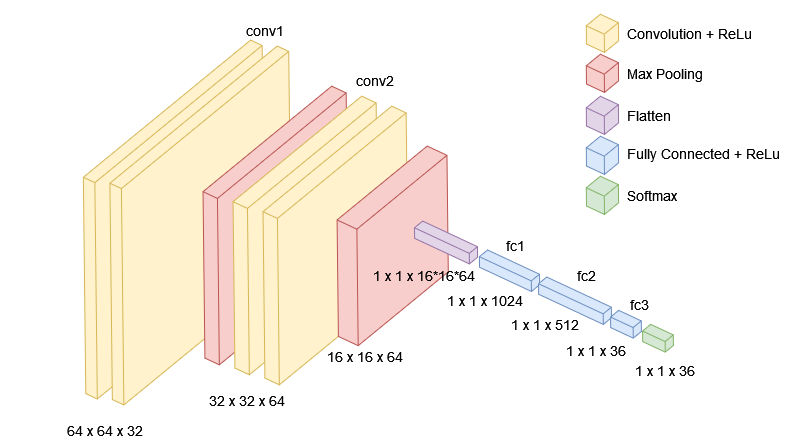

Figure 2 - CNN Diagram with respective layers


In [9]:
class CharacterCNN(nn.Module):
    def __init__(self, num_classes):
        super(CharacterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [10]:
num_classes = 36  # 26 lowercase letters + 10 numbers
model = CharacterCNN(num_classes)
print(model)

CharacterCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=36, bias=True)
)


### Data Augmentation and Dataset Classes

After evaluating the dataset provided, a difference was noticed regarding the amount of numbers and letters. There were a lot more numbers than letters which meant that the dataset was unbalanced, both in the test and train of the hard and soft directories.

The group's responde to this was to implement two dataset classes. In both classes, the preprocessing function was used to get the individual letters images and a simple string manipulation procedure was used to obtain the labels, correspondent to each image.

The main differences in the two classes were:

1 - CaptchaDataset - in this class the number of letters were increased with the intent of balancing out the dataset. To remove the repetitiveness of just adding the photo three times, the added leters were augmented with a random rotation within [0, 10] degrees. The numbers were not increased.

2 - CaptchaDatasetFinal - in this class, no increase of numbers or letters was done, which means that the rotation augment was not performed.

<br>

The augmentation used in both datasets had two simple transformations:
* Transformation of the input image to tensor. The pixel value is converted to the range [0.0,1.0].
* Normalization of the tensor with mean 0 and std 1.

The augmentation used only in the CapctchaDataset, as explained before used the transformation:
* Random Rotation of [0, 10] degrees.

In [11]:
# Data augmentation / Normalization
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0],
                                 [1]
                                 )
                             ])

def get_transforms_aug():
  return transforms.Compose([
                            transforms.RandomRotation(degrees=10)
                            ])

tfms = get_transforms()
tfms_aug = get_transforms_aug()

In [12]:
class CaptchaDatasetFinal(data.Dataset):

    def __init__(self, path, transforms):
        super().__init__()
        self.path = path
        self.generate_data()
        self.transforms = transforms

    def generate_data(self):
        # Put images in data variable
        data = []
        label = []
        label_unp = []
        data_unp = []
        images = glob.glob(self.path)
        concatenated_tensor_data = torch.tensor([])
        concatenated_tensor_label = torch.tensor([])

        for fname in images:
          img = cv2.imread(fname)

          directory_name = os.path.basename(fname)
          directory_name = os.path.splitext(directory_name)[0]
          individual_letters = [letter for letter in directory_name]

          img_segmented = preprocess_testing(img, individual_letters)
          if(len(img_segmented) == len(individual_letters)):
            for img_s in img_segmented:
              data.append(img_s)

            for letter in individual_letters:
              letter = convert_char_to_int(letter)
              label.append(letter)

        # Devemos ter tensors na data e labels
        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        self.size = len(self.label)
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]

        if self.transforms:
            # Apply transforms to the image
            data_point = self.transforms(data_point)

        return data_point, data_label



In [13]:
class CaptchaDataset(data.Dataset):

    def __init__(self, path, transforms, transforms_aug):
        super().__init__()
        self.path = path
        self.generate_data()
        self.transforms = transforms
        self.transforms_aug = transforms_aug

    def generate_data(self):
        # Put images in data variable
        data = []
        label = []
        images = glob.glob(self.path)

        for fname in images:
            img = cv2.imread(fname)

            directory_name = os.path.basename(fname)
            directory_name = os.path.splitext(directory_name)[0]
            individual_letters = [letter for letter in directory_name]

            img_segmented = preprocess_testing(img, individual_letters)
            if len(img_segmented) == len(individual_letters):
                for img_s, letter in zip(img_segmented, individual_letters):
                  data.append(img_s)
                  letter = convert_char_to_int(letter)
                  label.append(letter)
                  if((letter >= 10) and ("train" in fname)):
                      for _ in range(3):
                        data.append(img_s)
                        label.append(letter)

        # Devemos ter tensores na data e labels
        self.data = data
        self.label = label

    def __len__(self):
        # Number of data points we have.
        self.size = len(self.label)
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as a tuple
        data_point = self.data[idx]
        data_label = self.label[idx]

        if self.transforms:
            # Apply transforms to the image
            data_point = self.transforms(data_point)

        if self.transforms_aug:
          if(data_label >= 10):
            data_point = self.transforms_aug(data_point)

        return data_point, data_label


In [14]:
captchadata_train = CaptchaDataset(path = '/content/Dataset/CAPTCHA_dataset/soft/train/*.png', transforms = tfms, transforms_aug = tfms_aug)
captchadata_train_fin = CaptchaDatasetFinal(path = '/content/Dataset/CAPTCHA_dataset/soft/train/*.png', transforms = tfms)
captchadata_test = CaptchaDatasetFinal(path = '/content/Dataset/CAPTCHA_dataset/soft/test/*.png', transforms = tfms)

### Dataloader

The DataLoader function of the PyTorch was used for easy acess to the samples. The data was put into batches of size 64 in the train, which made it memory-efficient, and was shuffled to prevent bias.

Three dataloaders were created: two for training and one for testing. In the training the two dataset classes explained before were used for the two dataloaders and for the testing the CaptchaDatasetFinal class was used.

In [15]:
data_loader_train = data.DataLoader(captchadata_train, batch_size=64, shuffle = True)
data_loader_train_fin = data.DataLoader(captchadata_train_fin, batch_size=64, shuffle = True)
data_loader_test = data.DataLoader(captchadata_test, shuffle = True)

### Loss function and Optimizer

Relatively to the Loss Function and Optimizer, the Cross Entropy Loss function was used since the problem relies on multi-class classification.
Some class weights were added having in mind the representation of a certain class and the final accuracy. These topics will be discussed in the final part of the project.

In [16]:
from torch.optim import Adam, SGD, NAdam

# Define the loss function
class_weights = torch.ones(num_classes)

class_weights[0] = 0.85
class_weights[1] = 0.85
class_weights[23] = 0.5

loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9)

### Train Function

If the model needed to be saved for later loading, one could use the ```saveModel``` method.

The Train Function iterates over the dataloader and loads the images and labels to the device available (preferably GPU). Then the images go through the model, which generates the predictions. The predictions and labels are compared so that the loss is calculated and acumulated. The optimizer gradient is set to zero to prevent accumulation. Finally backpropagation occurs and the optmizer does the step.

For each epoch, it was possible to obtain the accuracy and loss values. Moreover, it would be important to register the evolution of both the validation and training datasets, to assess possible overfitting. Therefore, the dataloader correspondent to the test was also an input of the function.

At the end, some metric are calculated, specifically, the average loss and average accuracy per batch. There is also the option to save the model.



In [17]:
from torch.autograd import Variable

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader_train: torch.utils.data.DataLoader,
          dataloader_test: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):

    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0

    train_loss_evo = []
    train_acc_evo = []

    val_loss_evo = []
    val_acc_evo = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader_train, 0):

            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader_train)
        train_acc = train_acc / len(dataloader_train)

        train_loss_evo.append(train_loss)
        train_acc_evo.append(train_acc)

        #Validation
        model.eval()
        val_acc = 0.0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in dataloader_test:
                images = images.to(device)
                labels = labels.to(device)
                y_pred = model(images)
                loss = loss_fn(y_pred, labels)
                val_loss += loss.item()
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                val_acc += (y_pred_class == labels).sum().item() / len(y_pred)

        val_loss = val_loss / len(dataloader_test)
        val_acc = val_acc / len(dataloader_test)
        val_loss_evo.append(val_loss)
        val_acc_evo.append(val_acc)

        path = "./myModel_" +str(epoch)+ ".pth"
        #saveModel(model, path = path)


        if train_acc > best_accuracy:
            path = str(path_model)
            #saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    if num_epochs > 1:
      plt.xlabel("Epochs")
      plt.ylabel("Loss and Accuracy")
      plt.plot(train_loss_evo, linestyle = 'dotted',  label='Loss train')
      plt.plot(train_acc_evo, linestyle = 'dotted',  label='Acc val')
      plt.plot(val_loss_evo, linestyle = 'dotted',  label='Loss train')
      plt.plot(val_acc_evo, linestyle = 'dotted',  label='Acc val')
      plt.legend(loc='lower right')
      plt.show()

    return best_loss, best_accuracy, best_epoch

### Train

The train technique used was to do 17 epochs using the dataloader with the balanced dataset followed by 1 epoch with the unbalanced dataset dataloader. The last epoch seemed to improve the accuracy because the test dataset presented was also umbalanced. However the goal was to obtain a model capable of identifying any type of test data without a priori knowledge about its composition, hence the 17 epochs with a balanced dataset.

Best Epoch # 0  Loss= 1.3138176059340412  Accu= 0.612874809014515
Best Epoch # 1  Loss= 0.5355841069776107  Accu= 0.8262557295645531
Best Epoch # 2  Loss= 0.41242386934591485  Accu= 0.8623472116119175
Best Epoch # 3  Loss= 0.33274387678201184  Accu= 0.8877172459893048
Best Epoch # 4  Loss= 0.28412855442035645  Accu= 0.9020960656990069
Best Epoch # 5  Loss= 0.24677303993606312  Accu= 0.9139849121466769
Best Epoch # 6  Loss= 0.2171249696715949  Accu= 0.9229898777692895
Best Epoch # 7  Loss= 0.19612381564463205  Accu= 0.9294260886172652
Best Epoch # 8  Loss= 0.18142885456588817  Accu= 0.932393525592055
Best Epoch # 9  Loss= 0.16363029586758843  Accu= 0.9398706073338426
Best Epoch # 10  Loss= 0.15206101434554328  Accu= 0.9439147249809015
Best Epoch # 11  Loss= 0.13877972408850245  Accu= 0.948663101604278
Best Epoch # 12  Loss= 0.1263063022119795  Accu= 0.953566653934301
Best Epoch # 13  Loss= 0.11921974561391349  Accu= 0.9551136363636363
Best Epoch # 14  Loss= 0.10868195896161431  Accu= 0.

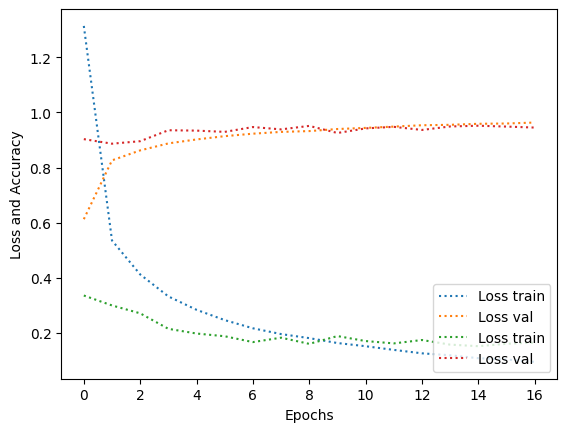

In [18]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader_train=data_loader_train,
                                                    dataloader_test=data_loader_test,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 17,
                                                    path_model = str("./myModel_best.pth"),
                                                    verbatim = True)



In [19]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader_train=data_loader_train_fin,
                                                    dataloader_test=data_loader_test,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 1,
                                                    path_model = str("./myModel_best.pth"),
                                                    verbatim = True)

Best Epoch # 0  Loss= 0.0809775873073904  Accu= 0.969310538116592


### Test Function

During the test the model is set to evaluation mode, which disables dropouts. Then, the computation of backpropagation gradients is prevented with the ```torch.no_grad()```. After these restraints, it iterates through the data in the dataloader, predicting the labels. Accuracy and loss are still accumulated. Finnaly, at the end of iteration, the average accuracy and average loss per batch are calculated.  

In [20]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            #print(convert_int_to_char(y_pred_class))
            test_acc += (y_pred_class == labels).sum()
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    #print(test_acc, " ", len(dataloader))

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc


### Test

For testing, the dataloader correspondent to the soft test dataset was used.

In [21]:
print('Finished Training')
# Test which classes performed well
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=data_loader_test,
                                    loss_fn=loss_fn,
                                        device=device,
                                        verbatim = True)

print(y_pred)

Finished Training
Loss = 0.14999066535252265   Accuracy= tensor(0.9540, device='cuda:0')
[17]


To experiment the classification with an example test image:

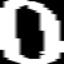

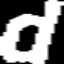

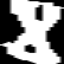

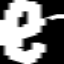

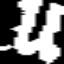

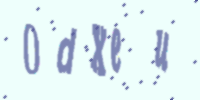

Loss = 0.13168670585146175   Accuracy= tensor(1., device='cuda:0')


In [22]:
# Experiment the classification for one image 0411j.png from soft test
captchadata_ex = CaptchaDatasetFinal(path = '/content/Dataset/CAPTCHA_dataset/soft/test/0dxeu.png', transforms = tfms)
for img in captchadata_ex.data:
  cv2_imshow(img)
data_loader_ex = data.DataLoader(captchadata_ex)

burh = cv2.imread('/content/Dataset/CAPTCHA_dataset/soft/test/0dxeu.png')
cv2_imshow(burh)

y_pred = []
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=data_loader_ex,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)


### Full CAPTCHA Accuracy

The model presented a high accuracy in the training and testing using individual characters, however that did not entail a high accuracy in the full CAPCTHA. For the CAPCTHA to be well classified, all its characters must be predicted correctly.

The funtion ```get_predictions``` was created to aid the various metrics used to verify the sucess of the model, such as overall CAPCTCHA accuracy, confusion matrix and individual character accuracy. It uses the model and a provided dataloader to obtain the character images, predictions and labels.

Regarding the full CAPTCHA accuracy, we loaded the images and labens into an example dataloader and the use the predictions method explained before. For each image, the total accuracy was the mean of the individual character accuracy. Finally the histograms of the CAPTCHAs with four or five characters are presented along with the segmentation rate, overall and well segmented accuracies.




In [23]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():

        for (x, y) in iterator:
            x = x.to(device)
            y_pred  = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

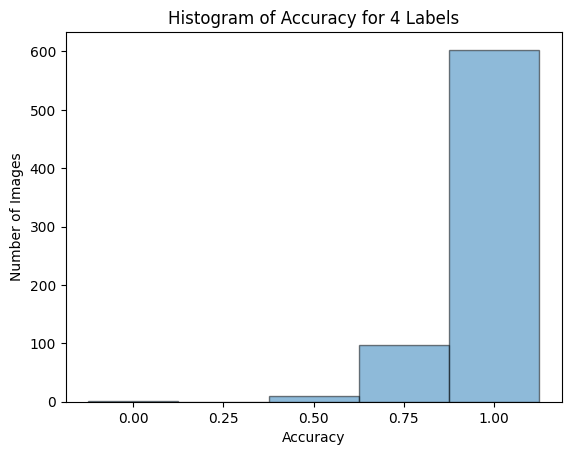

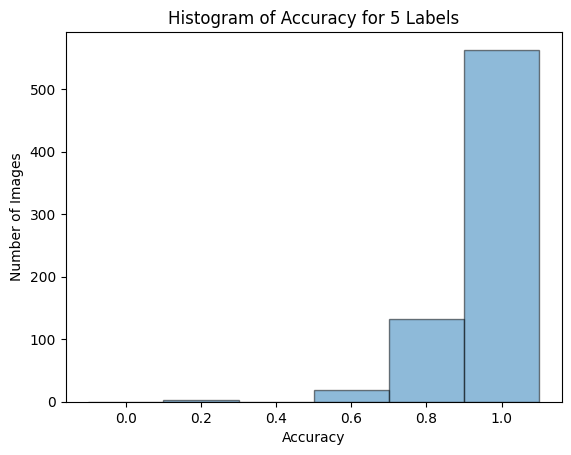

Total CAPTCHA right: 1166
Total images: 1432

Segmentation Rate: 99.51%

Overall Accuracy: 81.42%

Well Segmented Accuracy: 81.82%


In [24]:
import matplotlib.pyplot as plt

# Directory containing test images
test_directory = '/content/Dataset/CAPTCHA_dataset/soft/test'

# List all .png files in the directory
test_images = [f for f in os.listdir(test_directory) if f.endswith('.png')]

# Initialize variables to store results
correct_predictions = 0
sum_well_seg = 0
total_images = len(test_images)
accuracies_4_labels = []
accuracies_5_labels = []

# Loop over each test image
for test_image in test_images:
    # Create CaptchaDataset for the current image
    captchadata_ex = CaptchaDatasetFinal(path=os.path.join(test_directory, test_image), transforms=tfms)

    if len(captchadata_ex) != 0:
        sum_well_seg += 1
        # Create DataLoader for the current image
        data_loader_ex = data.DataLoader(captchadata_ex)

        # Perform classification using get_predictions
        images, labels, probs = get_predictions(model=model, iterator=data_loader_ex, device=device)

        # Calculate accuracy
        _, y_pred_class = torch.max(probs, 1)
        test_acc = round((y_pred_class == labels).float().mean().item(),2)

        # Check if the accuracy is 100%
        if test_acc == 1:
            correct_predictions += 1

        # Append the accuracy to the list based on the number of labels
        num_labels = len(captchadata_ex.label)
        if num_labels == 4:
            accuracies_4_labels.append(test_acc)
        elif num_labels == 5:
            accuracies_5_labels.append(test_acc)



# Create histograms for 4 labels
plt.hist(accuracies_4_labels, bins=[0, 0.25 ,0.5, 0.75, 1.0, 1.25], edgecolor='black', alpha=0.5, align='left')
plt.xlabel('Accuracy')
plt.ylabel('Number of Images')
plt.title('Histogram of Accuracy for 4 Labels')
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.show()

# Create histograms for 5 labels
plt.hist(accuracies_5_labels, bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], edgecolor='black', alpha=0.5, align='left')
plt.xlabel('Accuracy')
plt.ylabel('Number of Images')
plt.title('Histogram of Accuracy for 5 Labels')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

# Calculate overall accuracy
segmentation_rate = sum_well_seg / total_images
overall_accuracy = correct_predictions / total_images
well_seg_accuracy = correct_predictions / sum_well_seg
print(f"Total CAPTCHA right: {correct_predictions}")
print(f"Total images: {total_images}")
print(f"\nSegmentation Rate: {segmentation_rate:.2%}")
print(f"\nOverall Accuracy: {overall_accuracy:.2%}")
print(f"\nWell Segmented Accuracy: {well_seg_accuracy:.2%}")

### Confusion Matrix

To evaluate the miss classifications, a confusion matrix was built.

The amount of numbers is larger than the amount of letters, which emphasizes the unbalance behavior of the dataset in the test.

Generally, there are few situations of confusion, with the most important being:

*  "0" classified as "o"
*  "i" classified as "1"
*  "i" classified as "l"
*  "l" classified as "1"
*  "0" classified as "0"


The discussion of these results regarding the matrix are presented in the *Result Analysis* subsection.

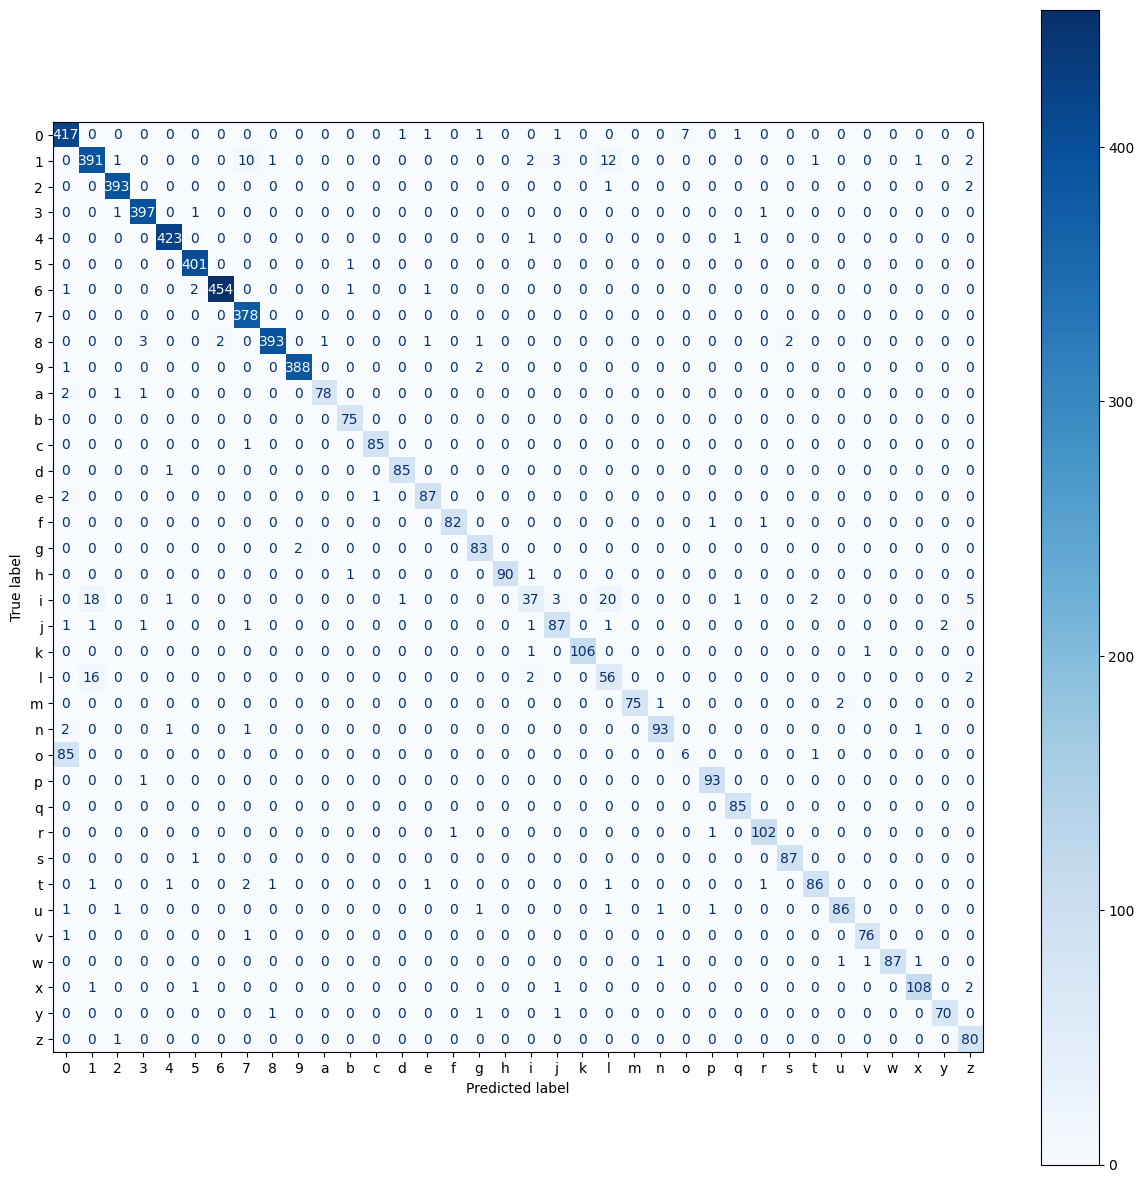

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = tuple(list(range(10)) + [chr(ord('a') + i) for i in range(26)])
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)

# Test the model using all testset
images, labels, probs = get_predictions(model, data_loader_test,  device)
pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels)

### Individual Character Accuracy

Finally, the information for each character was printed. This allowed the verification of classification success, and number of appearances for each character.

The critical characters where the "o", "l" and "i". All other characters had an accuracy higher than 90%.

The explanation for this result is present at the *Result Analysis* section.

In [26]:
from sklearn.metrics import accuracy_score
import numpy as np

# Test the model using all testset
images, labels, probs = get_predictions(model, data_loader_test,  device)
pred_labels = torch.argmax(probs, 1)

# Assuming labels and pred_labels are your true and predicted PyTorch tensors
labels = labels.tolist()
pred_labels = pred_labels.tolist()

# Calculate overall accuracy
overall_accuracy = accuracy_score(labels, pred_labels)
print(f"Overall Accuracy: {overall_accuracy:.2%}")

# Calculate accuracy for each label
unique_labels = set(labels)
label_accuracies = []

for label in unique_labels:
    correct_samples = sum(1 for true, pred in zip(labels, pred_labels) if true == label and pred == label)
    total_samples = labels.count(label)

    label_accuracy = correct_samples / total_samples if total_samples > 0 else 0
    label_accuracies.append(label_accuracy)

    print(f"Accuracy for Label {convert_int_to_char(label)}: {label_accuracy:.2%} (Total Samples: {total_samples})")


Overall Accuracy: 95.40%
Accuracy for Label 0: 97.20% (Total Samples: 429)
Accuracy for Label 1: 92.22% (Total Samples: 424)
Accuracy for Label 2: 99.24% (Total Samples: 396)
Accuracy for Label 3: 99.25% (Total Samples: 400)
Accuracy for Label 4: 99.53% (Total Samples: 425)
Accuracy for Label 5: 99.75% (Total Samples: 402)
Accuracy for Label 6: 98.91% (Total Samples: 459)
Accuracy for Label 7: 100.00% (Total Samples: 378)
Accuracy for Label 8: 97.52% (Total Samples: 403)
Accuracy for Label 9: 99.23% (Total Samples: 391)
Accuracy for Label a: 95.12% (Total Samples: 82)
Accuracy for Label b: 100.00% (Total Samples: 75)
Accuracy for Label c: 98.84% (Total Samples: 86)
Accuracy for Label d: 98.84% (Total Samples: 86)
Accuracy for Label e: 96.67% (Total Samples: 90)
Accuracy for Label f: 97.62% (Total Samples: 84)
Accuracy for Label g: 97.65% (Total Samples: 85)
Accuracy for Label h: 97.83% (Total Samples: 92)
Accuracy for Label i: 42.05% (Total Samples: 88)
Accuracy for Label j: 91.58% (To

### Result Analysis

The final overall CAPTCHA accuracy obtained in the soft dataset was around 80%, which is low when compared to the 95% individual character accuracy obtained in the test of the model.

In the confusion matrix it is possible to check the source of such low accuracy: the o's and 0's; 1's and i's; i's and l's. These pairs of characters present common features hence the difficulty in the classification by the model.


With the intent of increasing the accuracy, some tuning was made in the weight classes.
The weights associated to the o's and 0's, at first glance, might not make a lot of sense considering the fact that the o's are outnumbered by the 0's, but having augmented the data so that both classes have similar numbers in terms of representation, this weight should not be solely based on this factor.

<br>

The main reason behind it is the fact that the accuracy on the test went up significantly once the o's had a smaller weight associated. This can mean that:

* A lot of 0's were being classified as o's.
* The class "o" has reduced representation in the test dataset in comparison to the class "0" so guessing more 0's would benefit the final result.
* All of the above.

<br>

As it was possible to see by the final results, there was indeed a reduced representation of the o's meaning that guessing 0's more frequently than o's would benefit the final result.

<br>

Regarding the class "1", "l" and "i", the weight attributed to the 1's was reduced since the initial prediction was that there were going to be 1's classified as l's and i's, the reality was that a lot of i's and l's were being classified but not the other way around.

So there was a tradeoff where by decreasing the number of times the class "1" was guessed, the amount of times the class "l" and "i" appeared increased and so did the accuracy.

## Hard Dataset


### Preprocessing

Regarding the Hard Dataset, the image processing method used for the segmentation in the soft dataset proved to be insufficient since there is a line that goes through the entire image as noise, damaging the segmentation of individual digits. To deal with this issue, the following processing pipeline was added:

* Firstly, the Gaussian Adaptive Threshold was applied.
* Then a personalized erosion that will be explained in more detail after was used.
* To finalize, the small blob removal was enforced.

<br>

Using morphological processes such as erosion would remove the line but damage the digits severely, so instead a different approach was considered.
Since the line present in the image had an width inferior to the width of the digits, the following personalized erosion method was used:

For each pixel, their value was registered.

If,
\begin{equation}
  pixel[i][j] = 255
\end{equation}
<br>

The following conditions were established,

\begin{equation}
\begin{cases}
pixel[i][j-3] = 0,\\
pixel[i][j+3] = 0,
\end{cases}
\end{equation}

\begin{equation}
\begin{cases}
pixel[i-1][j] = 0,\\
pixel[i+1][j] = 0,
\end{cases}
\end{equation}

<br>

If either the first or second set of equations were verified, then

\begin{equation}
  pixel[i][j] = 0
\end{equation}

<br>

With these conditions, the removal of the line was executed with success without seriously damaging the digits in the CAPTCHA (assuming that a major part of letters and numbers in the dataset have a width greater than the noisy line).

After all these steps, the resulting images were as follows:

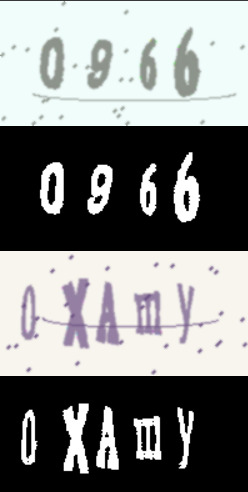

Figure 3 - Preprocessing results of the hard dataset

<br>

The final segmentation rate achieved was 92.74%, which was relatively smaller than the rate in the soft dataset (99.51%). This was expected since the noise has increased. Nevertheless, the sucess rate was still sufficiently good.

In [27]:
def preprocess_testing_hard(img, label):

  letters = []

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  thresh2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,21,2)

  rows, cols = thresh2.shape

  for i in range(rows-3):
      for j in range(cols-3):
          # Check if the pixel has transverse or longitudinal width of one pixel
          if thresh2[i][j] == 255 and (
                  (thresh2[i - 3][j] == 0 and thresh2[i + 3][j] == 0) or
                  (thresh2[i][j - 1] == 0 and thresh2[i][j + 1] == 0)):
                thresh2[i][j] = 0 # Set to white


  #Label connected components and get statistics
  num_labels, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(thresh2, connectivity=8)

  # Filter out small blobs based on area
  min_blob_area = 80 # Adjust this threshold as needed
  filtered_image = np.zeros_like(thresh2)
  for bruh in range(1, num_labels):
      if stats[bruh, cv2.CC_STAT_AREA] > min_blob_area:
          filtered_image[labeled_image == bruh] = 255

  contours, _ = cv2.findContours(filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])


  for c in contours:

    # Select the ROI of the paper sheet
    if(cv2.arcLength(c, True) > 50):

      # Calculate the bounding rectangle for the contour
      x, y, w, h = cv2.boundingRect(c)

      # Crop the region defined by the rectangle
      cropped_region = filtered_image[y:y + h, x:x + w]

      #resized_letter = cv2.resize(cropped_region, (64, 64))
      letters.append(cropped_region)

  # split the images containing 2 letters due to bad segmentation
  if(len(letters) != len(label) and len(letters) > 0):
    # Find the index of the letter with the maximum width
    max_width_index = max(range(len(letters)), key=lambda i: letters[i].shape[1])

    # Get the region with the maximum width
    max_width_region = letters[max_width_index]

    # Perform the cropping (assuming you want to split it into two equal halves)
    h, w = max_width_region.shape
    half_width = w // 2

    # Crop the left half
    left_half = max_width_region[:, :half_width]

    # Crop the right half
    right_half = max_width_region[:, half_width:]

    # Replace the letter with the two halves
    letters.pop(max_width_index)
    letters.insert(max_width_index, left_half)
    letters.insert(max_width_index + 1, right_half)

  letters_corrected = []

  for img in letters:
    resized_letter = cv2.resize(img, (64, 64))
    letters_corrected.append(resized_letter)

  return letters_corrected


# Directory path containing the images
directory_path = '/content/Dataset/CAPTCHA_dataset/hard/test/'

# File pattern to match
file_pattern = '*.png'

# Get a list of file paths that match the pattern
image_paths = glob.glob(directory_path + file_pattern)

# Variables for counting
total_count = len(image_paths)
seg_count = 0

for image_path in image_paths:
    # Read the image
    img = cv2.imread(image_path)

    # Extract the label from the file name or use a method to get the label
    directory_name = os.path.basename(image_path)
    directory_name = os.path.splitext(directory_name)[0]
    individual_letters = [letter for letter in directory_name]

    img_segmented = preprocess_testing_hard(img, individual_letters)
    if(len(img_segmented) == len(individual_letters)):
      seg_count += 1

print(f'Segmentation Accuracy: {(seg_count/total_count*100):.2f} %')

Segmentation Accuracy: 92.74 %


### Dataset Classes

The dataset classes used in the hard dataset were similar to the classes in the soft. The changes were the name of the class, the directory to get the dataset, and the preprocessing function used.

In [28]:
class CaptchaDatasetHardFinal(data.Dataset):

    def __init__(self, path, transforms):
        super().__init__()
        self.path = path
        self.generate_data()
        self.transforms = transforms

    def generate_data(self):
        # Put images in data variable
        data = []
        label = []
        label_unp = []
        data_unp = []
        images = glob.glob(self.path)
        concatenated_tensor_data = torch.tensor([])
        concatenated_tensor_label = torch.tensor([])

        for fname in images:
          img = cv2.imread(fname)

          directory_name = os.path.basename(fname)
          directory_name = os.path.splitext(directory_name)[0]
          individual_letters = [letter for letter in directory_name]

          img_segmented = preprocess_testing_hard(img, individual_letters)
          if(len(img_segmented) == len(individual_letters)):
            for img_s in img_segmented:
              data.append(img_s)

            for letter in individual_letters:
              letter = convert_char_to_int(letter)
              label.append(letter)

        # Devemos ter tensors na data e labels
        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        self.size = len(self.label)
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]

        if self.transforms:
            # Apply transforms to the image
            data_point = self.transforms(data_point)

        return data_point, data_label



In [29]:
class CaptchaDatasetHard(data.Dataset):

    def __init__(self, path, transforms, transforms_aug):
        super().__init__()
        self.path = path
        self.generate_data()
        self.transforms = transforms
        self.transforms_aug = transforms_aug

    def generate_data(self):
        # Put images in data variable
        data = []
        label = []
        images = glob.glob(self.path)

        for fname in images:
            img = cv2.imread(fname)

            directory_name = os.path.basename(fname)
            directory_name = os.path.splitext(directory_name)[0]
            individual_letters = [letter for letter in directory_name]

            img_segmented = preprocess_testing_hard(img, individual_letters)
            if len(img_segmented) == len(individual_letters):
                for img_s, letter in zip(img_segmented, individual_letters):
                  data.append(img_s)
                  letter = convert_char_to_int(letter)
                  label.append(letter)
                  if((letter >= 10) and ("train" in fname)):
                      for _ in range(3):
                        data.append(img_s)
                        label.append(letter)

        # Devemos ter tensores na data e labels
        self.data = data
        self.label = label

    def __len__(self):
        # Number of data points we have.
        self.size = len(self.label)
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as a tuple
        data_point = self.data[idx]
        data_label = self.label[idx]

        if self.transforms:
            # Apply transforms to the image
            data_point = self.transforms(data_point)

        if self.transforms_aug:
          if(data_label >= 10):
            data_point = self.transforms_aug(data_point)

        return data_point, data_label


In [ ]:
captchadata_train = CaptchaDatasetHard(path = '/content/Dataset/CAPTCHA_dataset/hard/train/*.png', transforms = tfms, transforms_aug = tfms_aug)
captchadata_train_fin = CaptchaDatasetHardFinal(path = '/content/Dataset/CAPTCHA_dataset/hard/train/*.png', transforms = tfms)
captchadata_test = CaptchaDatasetHardFinal(path = '/content/Dataset/CAPTCHA_dataset/hard/test/*.png', transforms = tfms)

### Dataloader

Regarding the dataloaders, the same thought process was used in comparison to the soft dataset.

In [ ]:
data_loader_train = data.DataLoader(captchadata_train, batch_size=64, shuffle = True)
data_loader_train_fin = data.DataLoader(captchadata_train_fin, batch_size=64, shuffle = True)
data_loader_test = data.DataLoader(captchadata_test, shuffle = True)

### Train

The hard dataset train still included 17 epochs of balanced dataset followed by 1 epoch of unchanged unbalanced dataset.

In [ ]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader_train=data_loader_train,
                                                    dataloader_test=data_loader_test,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 17,
                                                    path_model = str("./myModel_best.pth"),
                                                    verbatim = True)



In [ ]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader_train=data_loader_train_fin,
                                                    dataloader_test=data_loader_test,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 1,
                                                    path_model = str("./myModel_best.pth"),
                                                    verbatim = True)

### Test

In [ ]:
print('Finished Training')
# Test which classes performed well
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=data_loader_test,
                                    loss_fn=loss_fn,
                                        device=device,
                                        verbatim = True)

print(y_pred)

### Full CAPTCHA Accuracy

In the hard dataset, the overvall CAPTCHA accuracy was lower than the soft, due the lower segmentation rate.

In [ ]:
import os
import matplotlib.pyplot as plt

# Directory containing test images
test_directory = '/content/Dataset/CAPTCHA_dataset/soft/test/'

# List all .png files in the directory
test_images = [f for f in os.listdir(test_directory) if f.endswith('.png')]

# Initialize variables to store results
correct_predictions = 0
sum_well_seg = 0
total_images = len(test_images)
accuracies_4_labels = []
accuracies_5_labels = []

# Loop over each test image
for test_image in test_images:
    # Create CaptchaDataset for the current image
    captchadata_ex = CaptchaDatasetHardFinal(path=os.path.join(test_directory, test_image), transforms=tfms)

    if len(captchadata_ex) != 0:
        sum_well_seg += 1
        # Create DataLoader for the current image
        data_loader_ex = data.DataLoader(captchadata_ex)

        # Perform classification
        _, _, test_acc = test(model=model,
                              dataloader=data_loader_ex,
                              loss_fn=loss_fn,
                              device=device,
                              verbatim=False)

        # Check if the accuracy is 100%
        if test_acc == 1:
          correct_predictions += 1

        # Move the tensor to the CPU before using it as a NumPy array
        test_acc = test_acc.cpu().numpy()

        # Append the accuracy to the list based on the number of labels
        num_labels = len(captchadata_ex.label)
        if num_labels == 4:
            accuracies_4_labels.append(test_acc)
        elif num_labels == 5:
            accuracies_5_labels.append(test_acc)


# Create histograms for 4 labels
plt.hist(accuracies_4_labels, bins=[0, 0.25, 0.5, 0.75, 1.0], edgecolor='black', alpha=0.5, align='right')
plt.xlabel('Accuracy')
plt.ylabel('Percentage of Images')
plt.title('Histogram of Accuracy for 4 Labels')
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.show()

# Create histograms for 5 labels
plt.hist(accuracies_5_labels, bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], edgecolor='black', alpha=0.5, align='right')
plt.xlabel('Accuracy')
plt.ylabel('Percentage of Images')
plt.title('Histogram of Accuracy for 5 Labels')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

# Calculate overall accuracy
segmentation_rate = sum_well_seg / total_images
overall_accuracy = correct_predictions / total_images
well_seg_accuracy = correct_predictions / sum_well_seg
print(f"Total images: {total_images}")
print(f"\nSegmentation Rate: {segmentation_rate:.2%}")
print(f"\nOverall Accuracy: {overall_accuracy:.2%}")
print(f"\nWell Segmented Accuracy: {well_seg_accuracy:.2%}")

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = tuple(list(range(10)) + [chr(ord('a') + i) for i in range(26)])
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)

# Test the model using all testset
images, labels, probs = get_predictions(model, data_loader_test,  device)
pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels)

### Individual Character Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Test the model using all testset
images, labels, probs = get_predictions(model, data_loader_test,  device)
pred_labels = torch.argmax(probs, 1)

# Assuming labels and pred_labels are your true and predicted PyTorch tensors
labels = labels.tolist()
pred_labels = pred_labels.tolist()

# Calculate overall accuracy
overall_accuracy = accuracy_score(labels, pred_labels)
print(f"Overall Accuracy: {overall_accuracy:.2%}")

# Calculate accuracy for each label
unique_labels = set(labels)
label_accuracies = []

for label in unique_labels:
    correct_samples = sum(1 for true, pred in zip(labels, pred_labels) if true == label and pred == label)
    total_samples = labels.count(label)

    label_accuracy = correct_samples / total_samples if total_samples > 0 else 0
    label_accuracies.append(label_accuracy)

    print(f"Accuracy for Label {convert_int_to_char(label)}: {label_accuracy:.2%} (Total Samples: {total_samples})")

### Result Analysis

## Conclusion